## Download and Visualize NEON Hyperspectral Data
This script runs through a basic workflow of downloading a NEON hyperspectral tile over the NEON site SERC (Smithsonian Environmental Research Center), plots RGB and false color images of the tile, and plots the spectral signature of a single pixel in that tile. For more detailed tutorials on these, please see the NEON Learning Hub website, specifically the tutorials [Band Stacking, RGB & False Color Images](https://www.neonscience.org/resources/learning-hub/tutorials/neon-hsi-aop-functions-python) and [Plotting a Spectral Signature](https://www.neonscience.org/resources/learning-hub/tutorials/plot-spec-sig-tiles-python).

### Requirements
1. Python packages (only the non-standard ones are listed):
    - h5py
    - requests
    - urllib
2. This script calls on two modules which should be located in the sub-directory '../python_modules', which will be in the correct location if you clone this repository. These files are called `neon_aop_download_functions.py` and `neon_aop_hyperspectral.py`.

In [1]:
# download the required packages; this script calls on two modules (scripts) that need to be saved in the same directory as this notebook
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# add the python_modules to the path and import the python neon download and hyperspectral functions
sys.path.insert(0, '../python_modules')
import neon_aop_download_functions as neon_dl
import neon_aop_hyperspectral as neon_hs
%matplotlib inline 

In [3]:
# set the NEON data product ID and site, see links in comments below for more details on these
dpID='DP3.30006.001' # https://data.neonscience.org/data-products/DP3.30006.001
site = 'SERC' # https://www.neonscience.org/field-sites/serc

In [4]:
# use the neon_download function "list_available_urls" to show what data are available at SERC
neon_dl.list_available_urls(dpID,site)

['https://data.neonscience.org/api/v0/data/DP3.30006.001/SERC/2016-07',
 'https://data.neonscience.org/api/v0/data/DP3.30006.001/SERC/2017-07',
 'https://data.neonscience.org/api/v0/data/DP3.30006.001/SERC/2017-08',
 'https://data.neonscience.org/api/v0/data/DP3.30006.001/SERC/2019-05',
 'https://data.neonscience.org/api/v0/data/DP3.30006.001/SERC/2021-08']

In [5]:
# set the year of data to download
year='2021'

# set the data path where data will be downloaded (modify as needed!)
data_root_path = './data/'+site+'/'+year+'/'
h5_path = data_root_path+'refl/'

# create the data directory, if it doesn't exist
if not os.path.exists(h5_path):
    os.makedirs(h5_path)
    
# print the h5 path
print(data_root_path)

./data/SERC/2021/


TIP: When downloading data using the NEON API, in this case the h5 file, we recommend using a token. To set this up, please refer to https://www.neonscience.org/resources/learning-hub/tutorials/neon-api-tokens-tutorial

You would enter your token in the download function as follows, where 'token_string' will be your token string.

```python
my_token = 'token_string' 
neon_dl.download_aop_files('DP3.30006.001',
                           site,
                           year,
                           h5_path,
                           match_string='368000_4306000_reflectance.h5',
                           token=my_token)
```

In [6]:
# use the download_aop_files function to download a single reflectance (specified by UTM x_y coordinates)
# note, you will need to enter "y" to download
neon_dl.download_aop_files('DP3.30006.001',
                           site,year,h5_path,match_string='368000_4306000_reflectance.h5')

Download size: 629.07 MB
Do you want to continue with the download? (y/n) y
downloading NEON_D02_SERC_DP3_368000_4306000_reflectance.h5 to ./data/SERC/2021/refl/
token: False


In [7]:
# display the contents in the data directory
os.listdir(h5_path)

['NEON_D02_SERC_DP3_368000_4306000_reflectance.h5']

In [8]:
# set the variable h5_file to be the full path of the downloaded reflectance h5 tile
h5_file = os.path.join(h5_path,'NEON_D02_SERC_DP3_368000_4306000_reflectance.h5')

In [9]:
# read in the reflectance data using the aop_h5refl2array function
refl, refl_metadata, wavelengths = neon_hs.aop_h5refl2array(h5_file,'Reflectance')

Reading in  ./data/SERC/2021/refl/NEON_D02_SERC_DP3_368000_4306000_reflectance.h5


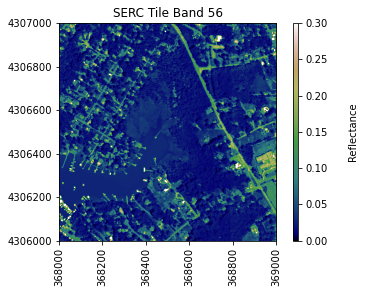

In [10]:
# plot a single band of data
band56 = refl[:,:,55] # note Python uses 0-based indexing, so 55 corresponds to band 56
neon_hs.plot_aop_refl(band56/refl_metadata['scale_factor'],
                      refl_metadata['extent'],
                      colorlimit=(0,0.3),
                      title='SERC Tile Band 56',
                      cmap_title='Reflectance',
                      colormap='gist_earth')

In [11]:
# pull out the true-color and false-color band combinations
rgb_bands = (58,34,19) # set the red, green, and blue bands
cir_bands = (90,34,19) # set the color infrared bands

# stack the 3-band combinations (rgb and cir) using stack_rgb function
rgb_unscaled = neon_hs.stack_rgb(refl,rgb_bands)
cir_unscaled = neon_hs.stack_rgb(refl,cir_bands)

# apply the reflectance scale factor
rgb = rgb_unscaled/refl_metadata['scale_factor']
cir = cir_unscaled/refl_metadata['scale_factor']

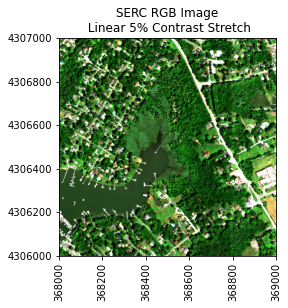

In [12]:
# plot the true color image (rgb)
neon_hs.plot_aop_rgb(rgb,
                     refl_metadata['extent'],
                     plot_title='SERC RGB Image')

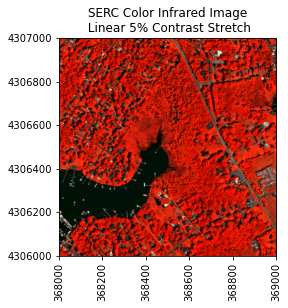

In [13]:
# plot the false color image (color infrared / cir)
neon_hs.plot_aop_rgb(cir,
                     refl_metadata['extent'],
                     plot_title='SERC Color Infrared Image')

In [14]:
# read in the spectral information from the center pixel (of the 1000 x 1000 m tile) to a dataframe
serc_pixel_df = pd.DataFrame()
serc_pixel_df['reflectance'] = refl[500,500,:]
serc_pixel_df['wavelengths'] = wavelengths

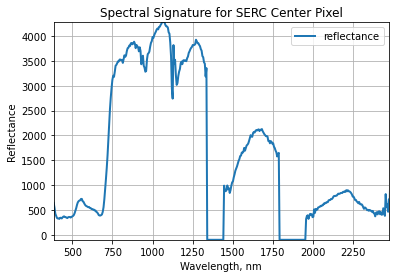

In [15]:
# plot the spectral signature
serc_pixel_df.plot.line(x='wavelengths',y='reflectance',linewidth=2)
plt.title('Spectral Signature for SERC Center Pixel'); ax = plt.gca() 
# set the x limit to the 98th percentile - this cuts out some of the noisy data at the SWIR edge of the spectrum
ax.set_xlim([np.min(serc_pixel_df['wavelengths']),np.percentile(serc_pixel_df['wavelengths'],98)])
ax.set_ylim([np.min(serc_pixel_df['reflectance']),np.percentile(serc_pixel_df['reflectance'],98)])
ax.set_xlabel("Wavelength, nm")
ax.set_ylabel("Reflectance")
ax.grid('on')